# Data Preprocessing:

Preprocesssing and cleaning the data involves handling missing values, removing duplicates, correcting errors, and dealing with outliers aims to improve data quality, accuracy, and the robustness of any insights or predictions derived from it.

In [17]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('Dataset/Original_dataset.csv')

## missing values

providing a quick way to inspect the presence of missing values in a DataFrame and understand which columns contain missing data and how many missing values are present in each column.

In [18]:
# checking missing value
missing_values= df.isna().sum() #calculates the number of missing values for each column in the DataFrame 
print(missing_values)

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


## duplicated values 

checking for and handle duplicated rows in a DataFrame. If duplicate rows are found, they can be removed to ensure data integrity and accuracy in subsequent analysis. If no duplicates are found, the code provides feedback confirming this.

In [19]:
# Check for duplicated rows
duplicate_rows = df[df.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows values found! Removing duplicates...")
    
else:
    print("No duplicate rows values found.")

No duplicate rows values found.


checking for and handle duplicate values in a specific column(id), which can be useful for ensuring data integrity and consistency.

In [20]:
# Check for duplicate values in the 'id' column
duplicate_ids = df.duplicated(subset=['id'])

# Check if there are any duplicate 'id' values
if duplicate_ids.any():
    print("Duplicate 'id' values found!")
else:
    print("No duplicate 'id' values found.")

No duplicate 'id' values found.


## Removing outliers 

identify and remove outliers from numeric columns in a DataFrame, contributing to data preprocessing and cleaning tasks.

In [21]:
# outliers removing

# Iterate through each column
for col in df.columns:
    if col != 'diagnosis':  # Exclude 'diagnosis' column
        if np.issubdtype(df[col].dtype, np.number):  # Check if column is numeric
            # Define function to remove outliers based on mean for each column
            def remove_outliers_based_on_mean(column):
                mean = np.nanmean(column)  # Use np.nanmean() to handle NaN values
                std_dev = np.nanstd(column)
                lower_bound = mean - (2.5 * std_dev)
                upper_bound = mean + (2.5 * std_dev)
                filtered_column = column[(column >= lower_bound) & (column <= upper_bound)]
                return filtered_column

            # Apply the function to remove outliers from the column
            df[col] = remove_outliers_based_on_mean(df[col])

# Drop rows with any NaN values after removing outliers
df.dropna(inplace=True)

num_rows = df.shape[0]
print("Number of rows in the DataFrame after removing outliers:", num_rows)

Number of rows in the DataFrame after removing outliers: 451


## Encoding

We encode the classified column to convert categorical data into a numerical format that can be easily used for analysis or machine learning algorithms and to be ensure that the classification task can be performed accurately and efficiently on the dataset.

In [22]:
# Apply Label Encoding to the diagnosis column
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])

## Balancing data 

We need to check the data balance of the label class(diagnosis) and to do so we can count print the percentage of each class(M and B)

In [23]:
import matplotlib.pyplot as plt

#calculate the frequancy for each diagnosis
diagnosis_frequency = df['diagnosis'].value_counts(normalize=True)*100

print("The percentage of each diagnosis:\n" + diagnosis_frequency.to_string())

The percentage of each diagnosis:
0    69.40133
1    30.59867


from the privious code we can see clearly that the data balance not have a closely equl persentage so we aim to a 60% M and 40% B as it's the closest to equality and maintane as much as possible from the data.
To done this we identified which class is takiing the larger percentage(df_majority) and which is less(df_minority) then using proportional sampling to calculate number of the class M class which down sampled to rech the disaierd distribution. Lastly join the data and update our dataset.

In [24]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['diagnosis'] == 0]
df_minority = df[df['diagnosis'] == 1]

print("Number of samples in majority class:", len(df_majority))
print("Number of samples in minority class:", len(df_minority))

# Determine the number of instances to keep for the majority class
num_minority_samples = len(df_minority)
num_majority_samples_to_keep = int(num_minority_samples / 0.6 * 0.4)  # Keep 40% of the minority class

# Randomly undersample the majority class
df_majority_downsampled = df_majority.sample(n=num_majority_samples_to_keep, random_state=42)

print("Number of samples in undersampled majority class:", len(df_majority_downsampled))

# Combine majority class with minority class along rows (axis 0)
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Reset index to avoid duplicate indices in concatenated DataFrame
df_balanced.reset_index(drop=True, inplace=True)

print("Number of samples in balanced dataset:", len(df_balanced))
df = df_balanced
# Now df_balanced contains a 60%-40% representation of both classes with undersampling

#calculate the frequancy for each diagnosis
diagnosis_frequency = df['diagnosis'].value_counts(normalize=True)*100

#to ensure that out work was correct we reprint the percentage
print("The percentage of each diagnosis after balaansing:\n" + diagnosis_frequency.to_string())

Number of samples in majority class: 313
Number of samples in minority class: 138
Number of samples in undersampled majority class: 92
Number of samples in balanced dataset: 230
The percentage of each diagnosis after balaansing:
1    60.0
0    40.0


## Discretization

Discretization the numeric columns in the DataFrame df_balanced into a specified number of bins, except for the 'diagnosis' and 'id' columns, which are excluded from the process. Discretization can be useful for certain machine learning algorithms that require categorical features or for analyzing data in a more interpretable format.

Discretization simplifies the process of representing data, making it easier to analyze, interpret, and make decisions, and can be useful in some machine learning algorithms.

In [25]:
# Discretization

# Define number of bins
num_bins = 3

# Iterate through each column
for col in df_balanced.columns:
    # Exclude 'diagnosis' and 'id' columns
    if col not in ['diagnosis', 'id']:
        # Perform discretization using the cut function
        df_balanced[col] = pd.cut(df_balanced[col], bins=num_bins, labels=False, duplicates='drop')
        #The result of pd.cut() is a new Series where each value from the original column df_balanced[col] is
       # replaced with an integer representing the bin number to which it belongs. 
        #This discretized Series is then assigned back to the original DataFrame column df_balanced[col].


## Feature selection

We try to choose the best 10 feature beside the id and the diagnosis feature because according to most resourses it's enough to have 10 attributes to determine the breast cancer diagnosis

In [26]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'diagnosis' column
label_encoder = LabelEncoder()
df_balanced['diagnosis_encoded'] = label_encoder.fit_transform(df_balanced['diagnosis'])

# Select features and target variable
X = df_balanced.drop(columns=['id', 'diagnosis', 'diagnosis_encoded'])  # Features
y = df_balanced['diagnosis_encoded']  # Encoded target variable

# Calculate the correlation coefficients between features and target variable
correlation_values = np.abs(X.corrwith(y))

# Sort the correlation values in descending order
correlation_values.sort_values(ascending=False, inplace=True)

# Select the top k features based on correlation
k = 10  # Choose the desired number of features
selected_feature_names = correlation_values.head(k).index.tolist()
df_selected = df_balanced[['diagnosis', 'id'] + selected_feature_names]
print("Selected Features based on Correlation:")
print(selected_feature_names)


Selected Features based on Correlation:
['perimeter_worst', 'radius_worst', 'concave points_mean', 'perimeter_mean', 'concave points_worst', 'radius_mean', 'concavity_mean', 'area_mean', 'concavity_worst', 'area_worst']


## Normalization

Normalization is important because it makes our data easier for modeling and evaluation. By scaling all our features to a specific range, like between 0 and 1, normalization ensures that our numbers are in a consistent format. This consistency helps our models understand and learn from the data more effectively. It also makes it simpler to compare the importance of different features in our model. Overall, normalization makes our data more manageable and helps our models perform better.

In [115]:
#normalized data
from sklearn.preprocessing import StandardScaler
coulmns_to_normalize=selected_feature_names
data_to_normalize=df_selected[coulmns_to_normalize]

In [116]:
zscore_scaler=StandardScaler()
normalized_data_zscore=zscore_scaler.fit_transform(data_to_normalize)

In [117]:
df_selected[coulmns_to_normalize]=normalized_data_zscore

<ipython-input-117-02c0985be1f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[coulmns_to_normalize]=normalized_data_zscore


In [118]:
print("Z-score normalized data:")
print(df_selected)


Z-score normalized data:
     diagnosis      id  concave points_worst  perimeter_worst  perimeter_mean  \
0            0  903811             -1.269231        -0.844600       -0.966879   
1            0  864033             -1.269231        -0.844600       -0.966879   
2            0   91227             -1.269231        -0.844600       -0.966879   
3            0  914101             -1.269231        -0.844600       -0.966879   
4            0  868223             -1.269231        -0.844600       -0.966879   
..         ...     ...                   ...              ...             ...   
348          1  926125              1.446154         0.868871        2.379281   
349          1  926424              1.446154         0.868871        2.379281   
350          1  926682              0.088462         0.868871        0.706201   
351          1  926954              0.088462         0.868871        0.706201   
352          1  927241              1.446154         0.868871        0.706201   

  

In [119]:
#save the modified dataframe to new csv file 
df_selected.to_csv('Processed_dataset.csv',index=False)

# Summary of the data set:

In this section we are going to display a quick summary of the data including sample of row data, some graphs and tables and statistics summaries.
First we have to import the data, so we can work with it and display its content correctly.

In [120]:
dataCancer = df_selected

### data description:

In our dataset, we provide a comprehensive description of attributes along with their respective types. The dataset comprises 12 columns after data preprosseing, each representing distinct characteristics relevant to a particularzz context. For clarity, we specify the type of each attribute, ensuring a clear understanding of the data structure and facilitating efficient analysis:

note:
* The descriptionis only provided for unclear or hard to understand attributes.* 
The mea  and "worst" or largest (mean of the three largest values) of themain2 attributes were computed for each image, resulting the rest of_worst  attributes.

In [121]:
from IPython.display import display, HTML

html_content = """
<table style="border:1;">
  <thead>
    <tr>
      <th>No</th>
      <th>Name</th>
      <th>Type</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>ID number</td>
      <td>Nominal and Integer</td>
      <td>ID number that distinguishes different samples/data that have been taken from different patients</td>
    </tr>
    <tr>
      <td>2</td>
      <td>Diagnosis</td>
      <td>Nominal and Character</td>
      <td>A class attribute that determines the stage of the breast cancer either M(malignant) or B(benign)</td>
    </tr>
    <tr>
      <td>3</td>
      <td>Radius_mean</td>
      <td>Numeric and Float</td>
      <td>Distances from center to points on the perimeter</td>
    </tr>
    <tr>
      <td>4</td>
      <td>Perimeter_mean</td>
      <td>Numeric and Float</td>
      <td>The distance around the nuclear border</td>
    </tr>
    <tr>
      <td>5</td>
      <td>Area_mean</td>
      <td>Numeric and Float</td>
      <td>Size of tumor</td>
    </tr>
    <tr>
      <td>6</td>
      <td>Compactness_mean</td>
      <td>Numeric and Float</td>
      <td>Measures the similarity between the shape of a breast tumor and its fitting circle</td>
    </tr>
    <tr>
      <td>7</td>
      <td>Concavity_mean</td>
      <td>Numeric and Float</td>
      <td></td>
    </tr>
    <tr>
      <td>8</td>
      <td>Concave points_mean</td>
      <td>Numeric and Float</td>
      <td>The number of indentations present on the nuclear border</td>
    </tr>
    <tr>
      <td>9</td>
      <td>Radius_worst</td>
      <td>Numeric and Float</td>
      <td></td>
    </tr>
    <tr>
      <td>10</td>
      <td>Perimeter_worst</td>
      <td>Numeric and Float</td>
      <td></td>
    </tr>
    <tr>
      <td>11</td>
      <td>Concavity_worst</td>
      <td>Numeric and Float</td>
      <td></td>
    </tr>
    <tr>
      <td>12</td>
      <td>Concave points_worst</td>
      <td>Numeric and Float</td>
      <td></td>
    </tr>
  </tbody>
</table>
"""

# Display the HTML content
display(HTML(html_content))


No,Name,Type,Description
1,ID number,Nominal and Integer,ID number that distinguishes different samples/data that have been taken from different patients
2,Diagnosis,Nominal and Character,A class attribute that determines the stage of the breast cancer either M(malignant) or B(benign)
3,Radius_mean,Numeric and Float,Distances from center to points on the perimeter
4,Perimeter_mean,Numeric and Float,The distance around the nuclear border
5,Area_mean,Numeric and Float,Size of tumor
6,Compactness_mean,Numeric and Float,Measures the similarity between the shape of a breast tumor and its fitting circle
7,Concavity_mean,Numeric and Float,
8,Concave points_mean,Numeric and Float,The number of indentations present on the nuclear border
9,Radius_worst,Numeric and Float,
10,Perimeter_worst,Numeric and Float,


### Sample of data:

First we going to display the first 5 row as a sample of the preprocessed data using the following code:

In [122]:
from IPython.display import display, HTML  # Import the HTML class so we can display the table

#print sample of 1st 5  
print('The first 5 rows of the raw data:')
data_sample = dataCancer.head(5)
# Generate HTML code from the sample
sample_table = data_sample.to_html(index=False)
# Display the HTML table in the notebook
display(HTML(sample_table))

The first 5 rows of the raw data:


diagnosis,id,concave points_worst,perimeter_worst,perimeter_mean,radius_worst,radius_mean,concave points_mean,concavity_mean,area_mean,compactness_mean,concavity_worst
0,903811,-1.269231,-0.8446,-0.966879,-0.84516,-0.985477,-0.791684,-0.686121,-0.62856,-0.695781,-0.628342
0,864033,-1.269231,-0.8446,-0.966879,-0.84516,-0.985477,-0.791684,-0.686121,-0.62856,-0.695781,-0.628342
0,91227,-1.269231,-0.8446,-0.966879,-0.84516,-0.985477,-0.791684,-0.686121,-0.62856,-0.695781,-0.628342
0,914101,-1.269231,-0.8446,-0.966879,-0.84516,-0.985477,-0.791684,-0.686121,-0.62856,-0.695781,-0.628342
0,868223,-1.269231,-0.8446,-0.966879,-0.84516,-0.985477,-0.791684,-0.686121,-0.62856,-0.695781,-0.628342


## Data Visualization

Displaying the data in a graphic format can help to analyze the data and reporting it. We used several charts as following:

We use the pie chart to show the percentage of different diagnosis in our data which turn out to be 62.7% benign and 37.3% malignant.

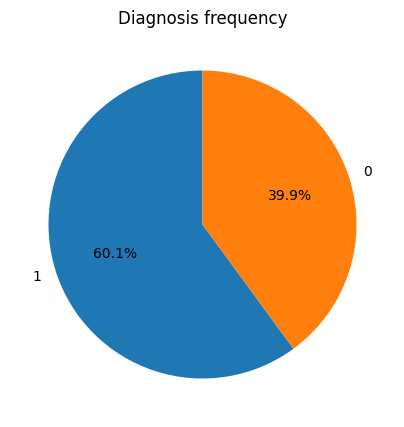

In [123]:
# graphs and tables show variable distribution , missing values
import matplotlib.pyplot as plt

#calculate the frequancy for each diagnosis
diagnosis_frequency = dataCancer['diagnosis'].value_counts(normalize=True)*100

#plot a ppie chart
diagnosis_frequency.plot.pie(autopct='%1.1f%%',figsize=(5,5),startangle=90)

#display the plot with appropriate apperance by changing the values of the attribute
plt.title('Diagnosis frequency')
plt.ylabel('')
plt.show()

Also, we use the plot box to show variable distribution for each attribute and comparing the values across different diagnosis.

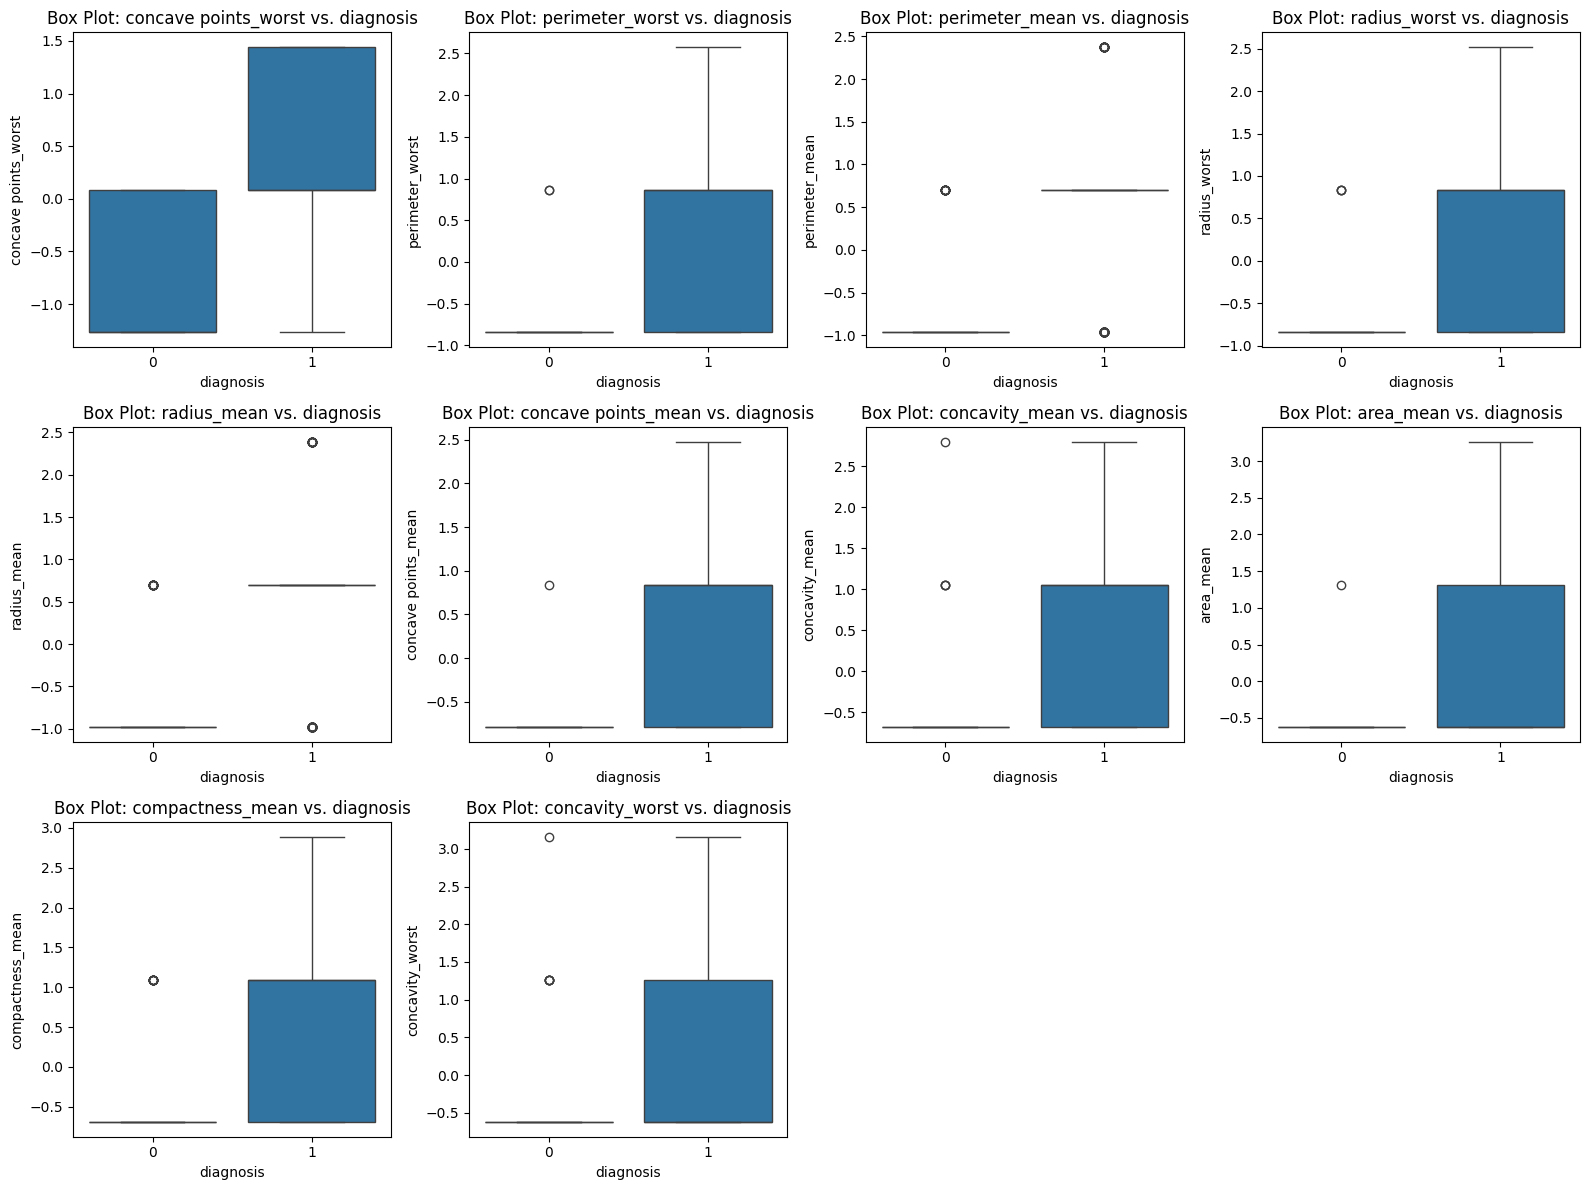

In [124]:
#this is to solve the problem of "ModuleNotFoundError: No module named ‘seabor’"
%pip install seaborn 
import seaborn as sns


target_column = 'diagnosis'

# choosing the numiric data only
feature_columns = dataCancer.columns[(dataCancer.columns != target_column) & (dataCancer.columns != 'id')]


# Determine the number of rows and columns for the subplot layout
num_features = len(feature_columns)
num_rows = (num_features - 1) // 4 + 1
num_cols = min(4, num_features)

# Create box plots for each feature grouped by 'diagnosis'
plt.figure(figsize=(16, 4 * num_rows))

for i, feature in enumerate(feature_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(x=target_column, y=feature, data=dataCancer)
    plt.title(f'Box Plot: {feature} vs. {target_column}')
    plt.xlabel(target_column)
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

Majority of our data is a numeric data and one of the best ways to visualize it is using the matrix of scatter plots(pair plot) in order to have a clear vision of the relationship between the data.

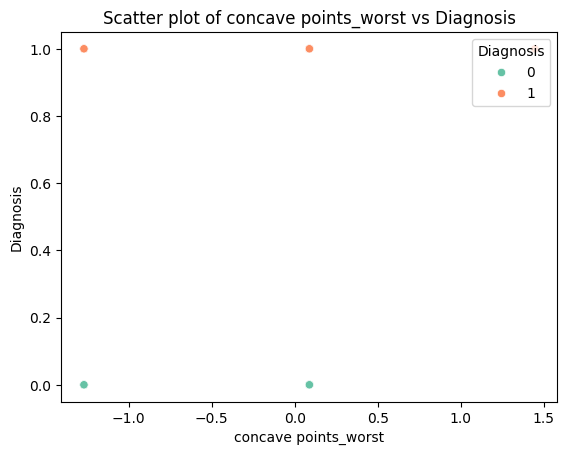

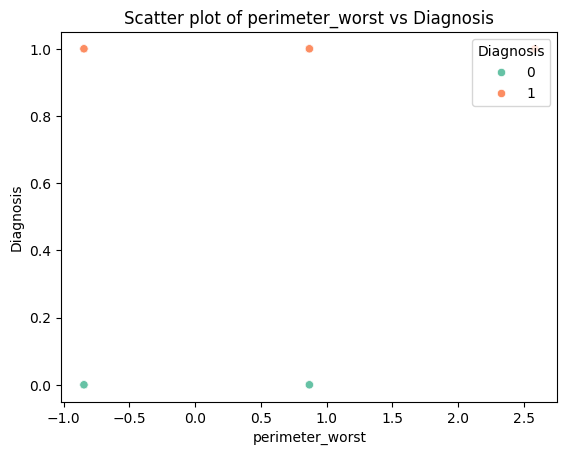

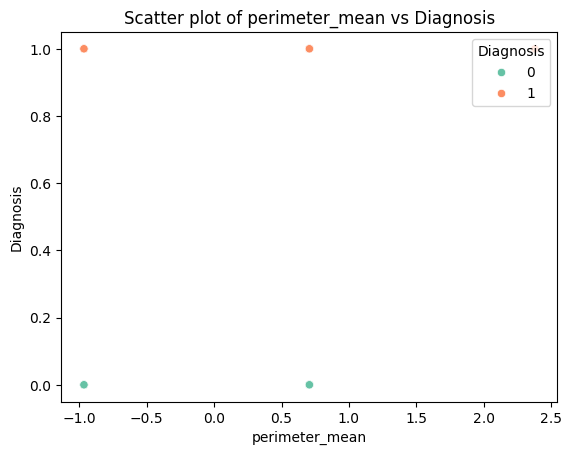

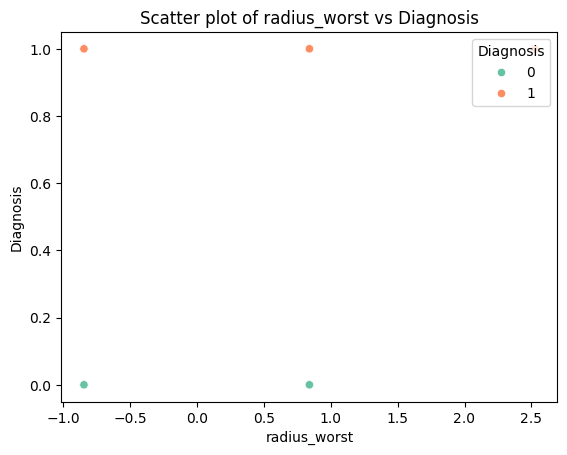

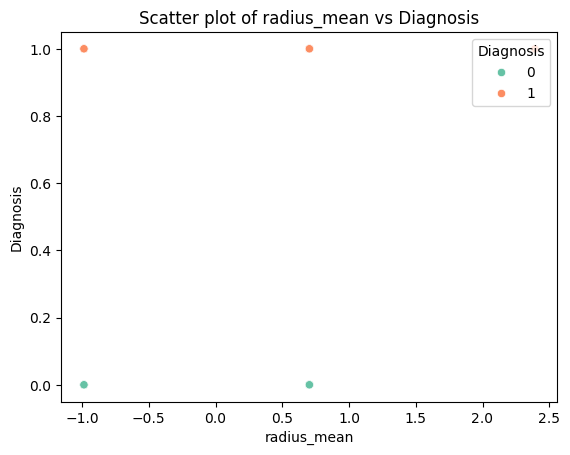

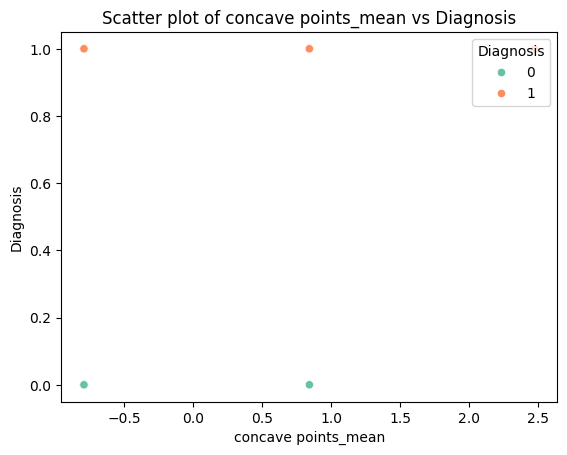

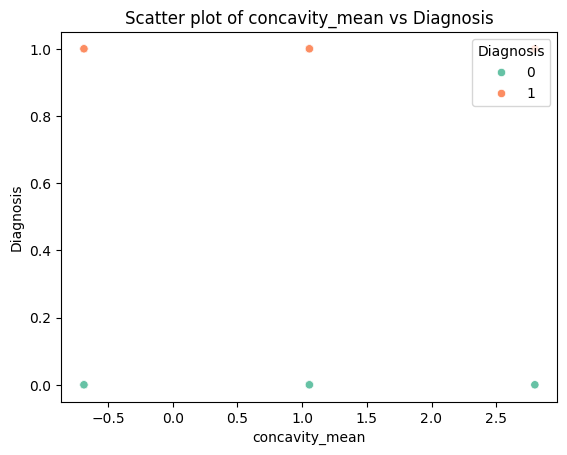

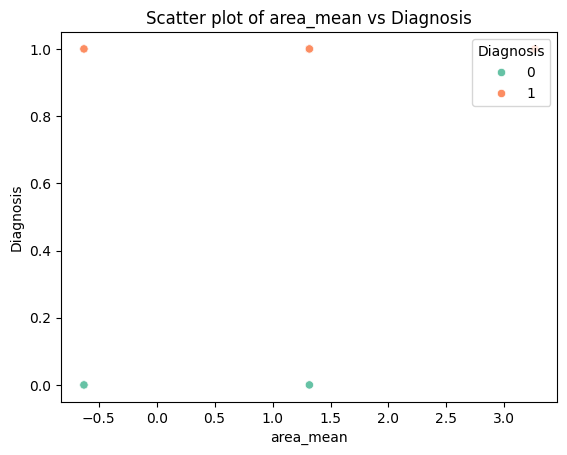

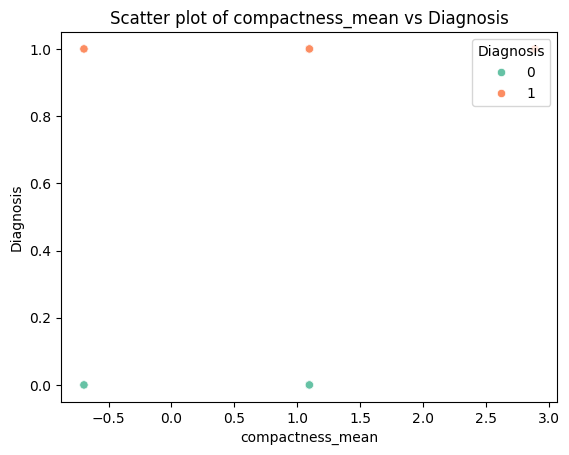

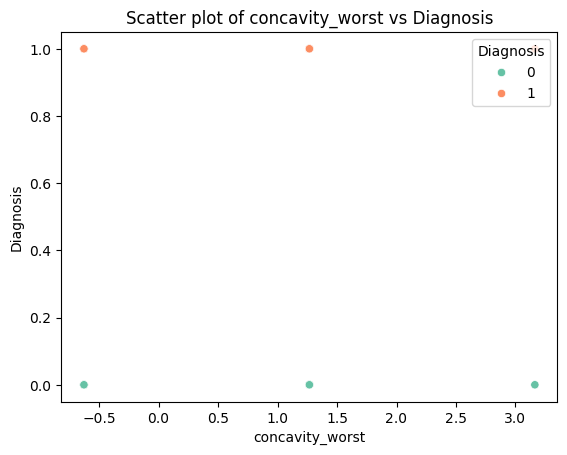

In [125]:

# Exclude the 'id' and 'diagnosis' columns
selected_features = dataCancer.drop(columns=['id', 'diagnosis'])

# Create scatter plots for each attribute against the target variable 'diagnosis'
for column in selected_features.columns:
    sns.scatterplot(data=dataCancer, x=column, y='diagnosis', hue='diagnosis', palette='Set2')
    plt.title(f"Scatter plot of {column} vs Diagnosis")
    plt.xlabel(column)
    plt.ylabel('Diagnosis')
    plt.legend(title='Diagnosis', loc='upper right')
    plt.show()


## Summary Statistics

It's important to take a look at the statistic summary to capture the different characteristics of our data set, such as the central tendency measurement and the variance. The table below shows these measurements that have been calculated by the python code above it.

In [126]:
import statistics as st

summary_data = []

for columnName in feature_columns:
    columnData = dataCancer[columnName]
    midrange = (max(columnData) + min(columnData)) / 2
    summary_data.append({
        'Feature': columnName,
        'Mean': st.mean(columnData),
        'Median': st.median(columnData),
        'Mode': st.mode(columnData),
        'Midrange': midrange,
        'Variance': st.variance(columnData)
    })

# Create the DataFrame after the loop
statistical_summaries = pd.DataFrame(summary_data)

# Generate HTML code from the DataFrame
statistical_summaries_table = statistical_summaries.to_html(index=False)
# Display the HTML table in the notebook
display(HTML(statistical_summaries_table))

Feature,Mean,Median,Mode,Midrange,Variance
concave points_worst,9.624030e-17,0.088462,0.088462,0.088462,1.002841
perimeter_worst,-2.107222e-17,-0.844600,-0.844600,0.868871,1.002841
perimeter_mean,6.384569e-17,0.706201,-0.966879,0.706201,1.002841
radius_worst,5.063623e-17,-0.845160,-0.845160,0.840385,1.002841
radius_mean,3.522521e-17,0.703229,0.703229,0.703229,1.002841
concave points_mean,2.107222e-17,-0.791684,-0.791684,0.842611,1.002841
concavity_mean,1.635456e-17,-0.686121,-0.686121,1.056330,1.002841
area_mean,4.812015e-17,-0.628560,-0.628560,1.317770,1.002841
compactness_mean,-9.435323e-17,-0.695781,-0.695781,1.096998,1.002841
concavity_worst,-2.138673e-17,-0.628342,-0.628342,1.267426,1.002841
